I will use deepface library for face detection and alignment
Steps


1. load and align pictures using retinaface model
2. resize images to be 240x240
3. set dataset directory format to (identity_name/pic_name) each identify has it's own images in one directory
4. split the data to test,train,valid
5. create a pair comparison csvfile to the validation and test data
6. save dataset to the preprocessed dataset directory

In [19]:
from sklearn.model_selection import train_test_split
import os
import sys
import time
import cv2
from deepface.commons.functions import preprocess_face
import random
import matplotlib.pyplot as plt
from src.efficentnet_train import utils,data_preprocessing


In [2]:
detector_backend="retinaface"
target_size=(240,240)

In [3]:
raw_data_path="../dataset/raw/img_celeba"
prep_data_path="../dataset/preprocessed/img_celeb"
img_names=os.listdir(raw_data_path)

In [4]:
print(f"Data size ={len(img_names)}")

Data size =202599


# Sample before preprocessing

In [9]:
random_pics=random.sample(img_names,5)

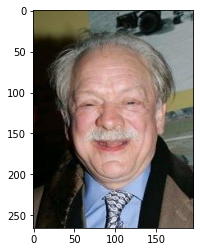

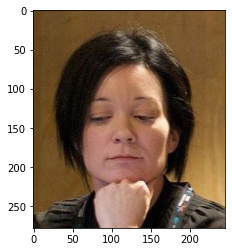

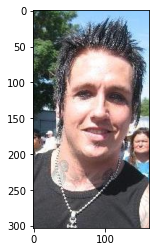

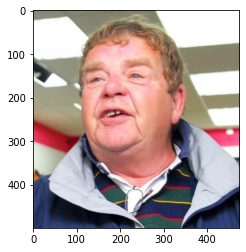

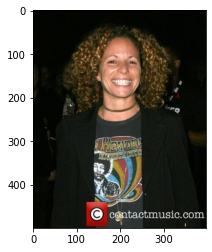

In [10]:
for pic_name in random_pics:
    img=cv2.cvtColor(cv2.imread(f"{raw_data_path}/{pic_name}"),cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()


## face image crop and alignment

### sample

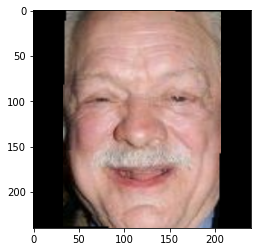

In [11]:
img=preprocess_face(f"{raw_data_path}/{random_pics[0]}",target_size=target_size,detector_backend=detector_backend)[0]
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
imgs_list=os.listdir(raw_data_path)
total_img=len(imgs_list)
cnt=0
time_sum=0
none_processed_imgs=[]
full_time_start=time.time()
for img_name in imgs_list:
    full_raw_img_path=f"{raw_data_path}/{img_name}"
    full_img_saving_path=f"{prep_data_path}/{img_name}"
    if os.path.exists(full_img_saving_path):#img already processed from past run
        total_img-=1
        continue
    img_process_start=time.time()
    try:
        img=preprocess_face(full_raw_img_path,target_size=target_size,detector_backend=detector_backend)[0]*255
        cv2.imwrite(full_img_saving_path,img)


    except:
        none_processed_imgs.append(f"{raw_data_path}/{img_name}")
    cnt += 1.0
    finished = int((cnt * 10) / total_img)
    remaining = 10 - finished
    img_process_end = time.time()
    time_sum += (img_process_end - img_process_start)
    avg_time = time_sum / cnt
    time_remaing = avg_time * (total_img - cnt)
    sys.stdout.write("\r Data processing  [" + str(
                "=" * int((cnt * 10) / total_img) + str("." * remaining) + "] time remaining = " + str(
                    time_remaing / 60.0)[:8]))



 Data processing  [==========] time remaining = 0.005962

In [28]:
full_time_taken_mn=int(((time_sum/cnt)*len(imgs_list))/60)
hr=int(full_time_taken_mn/60)
mn=full_time_taken_mn%60
print(f"Full time taken about= {hr}hr {mn}mn to preprocess images")

Full time taken about= 20hr 8mn to preprocess images


In [ ]:
# Split Dataset


- identities textfile
![identity_txt_file.png](assets/identity_txt_file.png)


## Steps
1. read img_name/identity txt file each line has image name and the identity number of this image
2. get identity_pics dictionary `{"identity-number":[list of photos]}`
3. split identities to train and test
4. create train and test folders
5. for each identity create a folder and add it's images in it `person_id/img_name`


In [2]:
identity_file_path="../dataset/preprocessed/identity_CelebA.txt"
identity_images_path="../dataset/preprocessed/img_celeb"
output_folder_path="../dataset/preprocessed/img_celeb_full"
identities_dict={} #identity:photos_cnt

In [ ]:
os.mkdir(f"{output_folder_path}/train")
os.mkdir(f"{output_folder_path}/test")


In [3]:
with open(identity_file_path,'r') as img_identity_file:
    lines=img_identity_file.readlines()
    no_file_imgs=len(lines)
    for line in lines:
        words=line[:-1].split(" ") # [-1] ignore /n
        identity=words[1]
        if identity in identities_dict:
            identities_dict[identity]+=1
        else:
            identities_dict[identity]=1

identities_list=list(identities_dict.items())

In [15]:
import numpy as np

train_identities_list,test_identities_list=train_test_split(identities_list,test_size=0.25)
train_identities_list=np.array(train_identities_list)
train_identities_set=set(train_identities_list[:,0]) # for fast access in the next loop

In [17]:
no_file_imgs=0
no_copied_imgs=0
no_train_imgs=0
no_test_imgs=0
total_img=0
with open(identity_file_path,'r') as img_identity_file:
    lines=img_identity_file.readlines()
    no_file_imgs=len(lines)
    for line in lines:
        words=line[:-1].split(" ")
        img_name,identity=words[0],words[1]

        if not os.path.exists(f"{identity_images_path}/{img_name}"):
            continue
        # check if a folder of the identity exists
        if identity in train_identities_set:
            new_img_dir=f"{output_folder_path}/train/{identity}"
            no_train_imgs+=1
        else:
            new_img_dir=f"{output_folder_path}/test/{identity}"
            no_test_imgs+=1
        total_img+=1


        if not os.path.exists(new_img_dir):
            os.mkdir(new_img_dir)
        utils.copyfile_to_dir(fpath=f"{identity_images_path}/{img_name}",dirPath=new_img_dir)
        no_copied_imgs+=1


In [18]:
print(f"Total Images : {total_img}  Train images: {no_train_imgs}  Test Images: {no_test_imgs}")

Total Images : 196913  Train images: 147944  Test Images: 48969


## meteaData

In [20]:
train_dataset_df=data_preprocessing.get_name_photos_list(f"{output_folder_path}/train")
test_dataset_df=data_preprocessing.get_name_photos_list(f"{output_folder_path}/test")

In [21]:
train_dataset_df.head()

,identity,no_photos
0,10,19
1,1000,8
2,10000,28
3,10001,30
4,10002,23


In [22]:
test_dataset_df.head()

,identity,no_photos
0,1,28
1,100,28
2,10011,2
3,10012,11
4,10013,13


In [23]:
print(f"no of train identities={train_dataset_df['no_photos'].count()}")
train_photos_count=train_dataset_df['no_photos'].sum()
print(f"no of train photos={train_photos_count}")

print(f"mean of photo count for each identity={int(train_dataset_df['no_photos'].mean())}")
print()


print(f"no of test identities={test_dataset_df['no_photos'].count()}")
test_photos_count=test_dataset_df['no_photos'].sum()
print(f"no of test photos={test_photos_count}")
print(f"mean of photo count for each identity={int(test_dataset_df['no_photos'].mean())}")



no of train identities=7632
no of train photos=147944
mean of photo count for each identity=19

no of test identities=2545
no of test photos=48969
mean of photo count for each identity=19


 Calculate memory needed to load the images one time to increase the speed of training because we will have triplet of (anchor_image , postive_image , negative_image ) so loading of each photo will be more than one time if we save it in memory we will get the image faster

In [24]:
#mermory needed to load  photos
photo_size=225*225
from_byte_to_mega = lambda x: x/(1024*1024)
print(f"train photos = {from_byte_to_mega(train_photos_count*photo_size*4)} mega byte")
print(f"test photos = {from_byte_to_mega(test_photos_count*photo_size*4)} mega byte")

train photos = 28570.804595947266 mega byte
test photos = 9456.846714019775 mega byte


In [33]:
print((16000*photo_size*4)/(1024**2))

3515.625
